# Spatial Patterns of Extremes

## Imports

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt

## Stop session if needed

In [ ]:
#spark.stop()

## Start Spark session

In [3]:
spark = SparkSession.builder.master('local[*]').appName('Climalyticsat').config('spark.driver.memory', '8g').config('spark.executor.memory', '8g').getOrCreate()

25/05/19 17:12:32 WARN Utils: Your hostname, arch-df23 resolves to a loopback address: 127.0.1.1; using 10.27.98.11 instead (on interface wlp2s0)
25/05/19 17:12:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/19 17:12:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/19 17:12:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load data and write out as Parquet

### Load all station's climate data

In [ ]:
climate_data = spark.read.csv('climate_all_stations.csv', header=True, inferSchema=True)

### Extract a “year” column for efficient time‐based pruning

In [ ]:
# turn string into a proper date, then pull out the year
climate_data = (
    climate_data
      .withColumn('date',   to_date('date', 'yyyy-MM'))
      .withColumn('year',   year('date'))
)

### Load and join stations metadata

In [ ]:
stations = (
    spark.read
         .csv('stations_metadata.csv', header=True, inferSchema=True)
         .withColumnRenamed('id', 'station_id')
         .withColumnRenamed('Höhe [m]', 'elevation')
         .select('station_id', 'elevation')
)

climate = climate_data.join(stations, on='station_id', how='inner')

#### Bucket elevation into (250m) bands

In [ ]:
climate = climate.withColumn(
    'elevation_band',
    (floor(climate.elevation / 250) * 250).cast('int')  # 0–249m → 0, 250–499m → 250, etc.
)

### Write out as Parquet, partitioned by year & elevation_band

In [ ]:
climate.write.partitionBy('year', 'elevation_band').parquet('extremes_parquet/')

## RQ2 - Spatial Patterns of Extremes
Which geographic zones (valleys, plateaus, alpine corridors) show the largest shifts in “hot days” (≥ 30 °C) and “frost days” (≤ 0 °C) since 1970?

### Load Parquet (qear, elevation_band)

In [4]:
climate = spark.read.parquet('extremes_parquet/')

### Add geogrpahic zones

In [5]:
# needed columns
# tage_tropen,Tropentage,"Zahl der Tropentage,  Tagesmaximum der Lufttemperatur in 2 m Höhe >=30.0°C",d
# tage_frost,Frosttage,"Zahl der Frosttage, 24-Stunden-Minimalwert der Lufttemperatur in 2m Höhe < 0.0 °C",d

climate = climate.withColumn(
    'zone',
    when(col('elevation') <= 700,      'valley')
   .when((col('elevation') > 700) & (col('elevation') <= 1500), 'plateau')
   .otherwise('alpine')
)

### Compute the “shift” since 1970

#### End-minus-start difference

In [6]:
# 1) total per station×year
zone_year_station = (
    climate
      .groupBy('zone','station_id','year')
      .agg(
        _sum('tage_tropen').alias('hot_days'),
        _sum('tage_frost').alias('frost_days')
      )
)

# 2) average per zone×year
zone_year = (
    zone_year_station
      .groupBy('zone','year')
      .agg(
        avg('hot_days' ).alias('hot_days'),
        avg('frost_days').alias('frost_days')
      )
)

In [7]:
first_decade = (zone_year
    .filter(col('year').between(1970,1979))
    .groupBy('zone')
    .agg(avg('hot_days').alias('hot_70s'),
         avg('frost_days').alias('frost_70s'))
)

last_decade = (zone_year
    .filter(col('year').between(2015,2024))
    .groupBy('zone')
    .agg(avg('hot_days').alias('hot_10s'),
         avg('frost_days').alias('frost_10s'))
)

shift = (first_decade
    .join(last_decade, 'zone')
    .withColumn('hot_shift',   col('hot_10s')   - col('hot_70s'))
    .withColumn('frost_shift', col('frost_10s') - col('frost_70s'))
)


In [8]:
# print the per-zone, per-decade averages
first_decade.show(truncate=False)
last_decade.show(truncate=False)

# print the computed shifts
shift.select('zone','hot_70s','hot_10s','hot_shift',
             'frost_70s','frost_10s','frost_shift') \
     .show(truncate=False)


+-------+--------------------+------------------+
|zone   |hot_70s             |frost_70s         |
+-------+--------------------+------------------+
|valley |5.023227582709836   |107.35605336086769|
|alpine |0.010368663594470046|193.37662147830332|
|plateau|1.1105882391258004  |145.25608204623128|
+-------+--------------------+------------------+



25/05/19 17:12:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+--------------------+------------------+
|zone   |hot_10s             |frost_10s         |
+-------+--------------------+------------------+
|valley |22.168443586858647  |85.33960060422382 |
|alpine |0.011428571428571429|182.2576797385621 |
|plateau|6.019327754871048   |124.71345044371608|
+-------+--------------------+------------------+



+-------+--------------------+--------------------+---------------------+------------------+------------------+-------------------+
|zone   |hot_70s             |hot_10s             |hot_shift            |frost_70s         |frost_10s         |frost_shift        |
+-------+--------------------+--------------------+---------------------+------------------+------------------+-------------------+
|valley |5.023227582709836   |22.168443586858647  |17.14521600414881    |107.35605336086769|85.33960060422382 |-22.016452756643872|
|alpine |0.010368663594470046|0.011428571428571429|0.0010599078341013823|193.37662147830332|182.2576797385621 |-11.118941739741217|
|plateau|1.1105882391258004  |6.019327754871048   |4.908739515745248    |145.25608204623128|124.71345044371608|-20.5426316025152  |
+-------+--------------------+--------------------+---------------------+------------------+------------------+-------------------+



#### Visualize with matplotlib

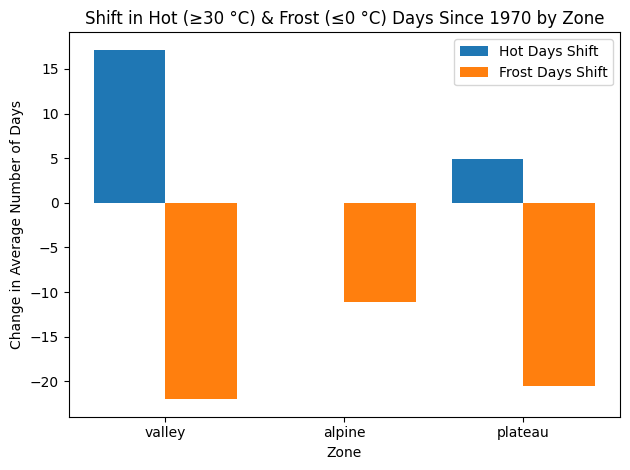

In [9]:

shift_pd = shift.toPandas()

zones      = shift_pd['zone']
hot_shift  = shift_pd['hot_shift']
frost_shift= shift_pd['frost_shift']
x = range(len(zones))

plt.figure()
plt.bar([i - 0.2 for i in x], hot_shift,   width=0.4, label='Hot Days Shift')
plt.bar([i + 0.2 for i in x], frost_shift, width=0.4, label='Frost Days Shift')
plt.xticks(x, zones)
plt.xlabel('Zone')
plt.ylabel('Change in Average Number of Days')
plt.title('Shift in Hot (≥30 °C) & Frost (≤0 °C) Days Since 1970 by Zone')
plt.legend()
plt.tight_layout()
plt.show()


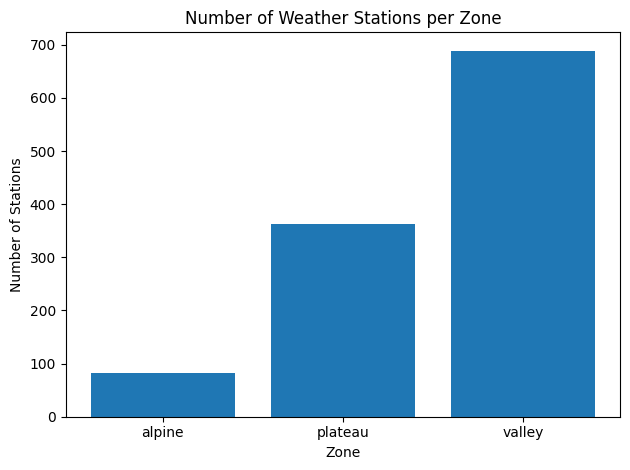

In [10]:
station_counts = (
    climate
      .select('station_id', 'zone')
      .distinct()
      .groupBy('zone')
      .agg(countDistinct('station_id').alias('num_stations'))
      .orderBy('zone')
)

# 3) Bring to Pandas & plot
station_counts_pd = station_counts.toPandas()

import matplotlib.pyplot as plt

zones  = station_counts_pd['zone']
counts = station_counts_pd['num_stations']
x      = range(len(zones))

plt.figure()
plt.bar(x, counts)
plt.xticks(x, zones)
plt.xlabel('Zone')
plt.ylabel('Number of Stations')
plt.title('Number of Weather Stations per Zone')
plt.tight_layout()
plt.show()

### Plot the full time-series by zone

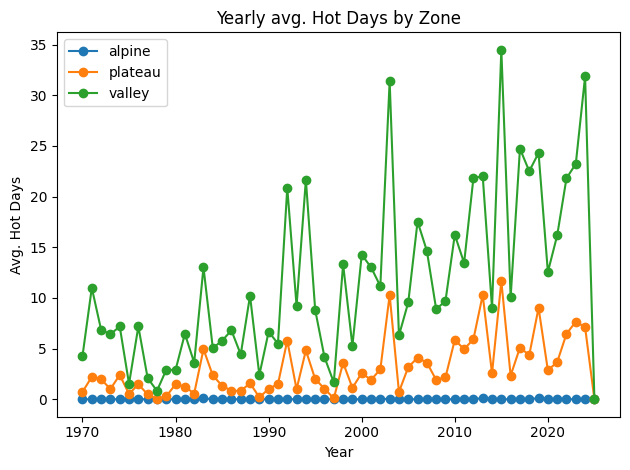

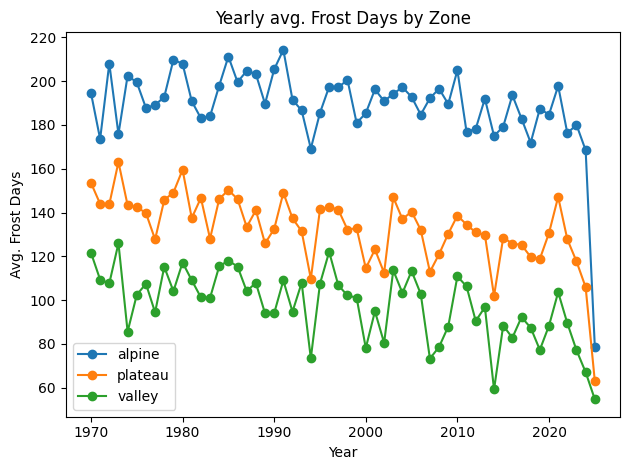

In [11]:
# 1) build your zone×year table (mean per station)
zone_ts = (
    climate
      .groupBy('zone','station_id','year')
      .agg(
        _sum('tage_tropen').alias('hot_days'),
        _sum('tage_frost').alias('frost_days')
      )
      .groupBy('zone','year')
      .agg(
         avg('hot_days').alias('hot_days'),
         avg('frost_days').alias('frost_days')
      )
      .orderBy('zone','year')
      .toPandas()
)

# 2) pivot and plot
for metric in ['hot_days','frost_days']:
    plt.figure()
    for zone, grp in zone_ts.groupby('zone'):
        plt.plot(grp['year'], grp[metric], marker='o', label=zone)
    plt.title(f"Yearly avg. {metric.replace('_',' ').title()} by Zone")
    plt.xlabel('Year')
    plt.ylabel(f"Avg. {metric.replace('_',' ').title()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Linear Regression

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# 1) Build your per‐zone time series (mean hot/frost days per station per year)
zone_year = (
    climate
      .groupBy('zone','station_id','year')
      .agg(
        _sum('tage_tropen').alias('hot_days'),
        _sum('tage_frost').alias('frost_days')
      )
      .groupBy('zone','year')
      .agg(
        avg('hot_days').alias('hot_days'),
        avg('frost_days').alias('frost_days')
      )
      .orderBy('zone','year')
)

# 2) Fit one regression per zone
slopes = []
for zone_name in ['valley','plateau','alpine']:
    sdf = zone_year.filter(col('zone') == zone_name)
    
    # assemble the feature vector (just year)
    va = VectorAssembler(inputCols=['year'], outputCol='features')
    sdf = va.transform(sdf)

    # hot‐day trend
    lr_hot = LinearRegression(featuresCol='features',
                              labelCol='hot_days')
    m_hot  = lr_hot.fit(sdf)
    # frost‐day trend
    lr_frost = LinearRegression(featuresCol='features',
                                labelCol='frost_days')
    m_frost  = lr_frost.fit(sdf)

    # extract and cast to plain Python floats
    slopes.append((
      zone_name,
      float(m_hot.coefficients[0]),
      float(m_frost.coefficients[0])
    ))

    # hot summary
    s_hot = m_hot.summary
    print(f"{zone_name} — hot days:")
    print(f"  slope = {m_hot.coefficients[0]:.3f} days/yr, R² = {s_hot.r2:.3f}, p = {s_hot.pValues[1]:.3e}")

    # frost summary
    s_f = m_frost.summary
    print(f"{zone_name} — frost days:")
    print(f"  slope = {m_frost.coefficients[0]:.3f} days/yr, R² = {s_f.r2:.3f}, p = {s_f.pValues[1]:.3e}")
    print()


# 3) Convert to a SparkDF (now schema inference will work)
slopes_df = spark.createDataFrame(
    slopes,
    schema=['zone','slope_hot','slope_frost']
)


25/05/19 17:13:06 WARN Instrumentation: [fb4610ed] regParam is zero, which might cause numerical instability and overfitting.
25/05/19 17:13:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/05/19 17:13:15 WARN Instrumentation: [7d5b8040] regParam is zero, which might cause numerical instability and overfitting.


valley — hot days:
  slope = 0.319 days/yr, R² = 0.380, p = 6.249e-07
valley — frost days:
  slope = -0.595 days/yr, R² = 0.371, p = 1.126e-07



25/05/19 17:13:24 WARN Instrumentation: [242d2d68] regParam is zero, which might cause numerical instability and overfitting.
25/05/19 17:13:32 WARN Instrumentation: [df5eb607] regParam is zero, which might cause numerical instability and overfitting.


plateau — hot days:
  slope = 0.097 days/yr, R² = 0.319, p = 7.524e-06
plateau — frost days:
  slope = -0.610 days/yr, R² = 0.381, p = 4.074e-08



25/05/19 17:13:40 WARN Instrumentation: [98fe9327] regParam is zero, which might cause numerical instability and overfitting.
25/05/19 17:13:48 WARN Instrumentation: [0e73ff20] regParam is zero, which might cause numerical instability and overfitting.


alpine — hot days:
  slope = 0.000 days/yr, R² = 0.001, p = 8.152e-01
alpine — frost days:
  slope = -0.468 days/yr, R² = 0.167, p = 2.213e-04



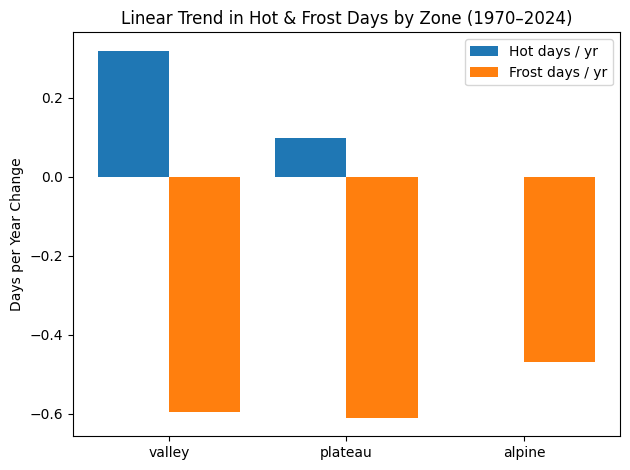

In [13]:
# 4) Plot with matplotlib
pd = slopes_df.toPandas()
x = range(len(pd))
plt.figure()
plt.bar([i-0.2 for i in x], pd['slope_hot'],   width=0.4, label='Hot days / yr')
plt.bar([i+0.2 for i in x], pd['slope_frost'], width=0.4, label='Frost days / yr')
plt.xticks(x, pd['zone'])
plt.ylabel('Days per Year Change')
plt.title('Linear Trend in Hot & Frost Days by Zone (1970–2024)')
plt.legend()
plt.tight_layout()
plt.show()